In [1]:
%cd ..
%ls

/home/nas3_userJ/dmkim/OnlineTSAD
cfgs/         data/  Exp/     logs/    outputs/  results/  train.py*  Vis/
checkpoints/  EDA/   hptune/  models/  plots/    test.py*  utils/     wandb/


In [2]:
import torch
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

from utils.metrics import get_summary_stats

from models.MLP import MLP

import wandb
import hydra
from omegaconf import DictConfig

from utils.logger import make_logger
from utils.argpass import prepare_arguments, configure_exp_id
from utils.tools import SEED_everything, plot_interval

import warnings
from data.load_data import DataFactory
from Exp.ReconBaselines import *

from easydict import EasyDict as edict
import yaml
import re
import copy

warnings.filterwarnings("ignore")

In [3]:
# load yaml
cfg = {}
loader = yaml.SafeLoader
loader.add_implicit_resolver(
    u'tag:yaml.org,2002:float',
    re.compile(u'''^(?:
     [-+]?(?:[0-9][0-9_]*)\\.[0-9_]*(?:[eE][-+]?[0-9]+)?
    |[-+]?(?:[0-9][0-9_]*)(?:[eE][-+]?[0-9]+)
    |\\.[0-9_]+(?:[eE][-+][0-9]+)?
    |[-+]?[0-9][0-9_]*(?::[0-5]?[0-9])+\\.[0-9_]*
    |[-+]?\\.(?:inf|Inf|INF)
    |\\.(?:nan|NaN|NAN))$''', re.X),
    list(u'-+0123456789.'))

# get cfg
model = "MLP"
with open("cfgs/test_defaults.yaml", "r") as file:
    basic_config = yaml.load(file, Loader=loader)
    cfg.update(basic_config)
with open(f"cfgs/model/{model}.yaml", "r") as file:
    model_config = yaml.load(file, Loader=loader)
    cfg.update({"model": model_config})
cfg['dataset'] = 'SWaT'
cfg["RevIN"] = 'ARevIN'
cfg["gamma"] = 0.5

In [4]:
args = prepare_arguments(cfg)
args.model.latent_dim = 128
args.window_size = 12
args.eval_batch_size = 1
args.dataset = "SWaT"
print(args)

logger = make_logger(os.path.join(args.log_path, f'{args.exp_id}.log'))
logger.info(f"Configurations: {args}")

# Data
logger.info(f"Preparing {args.dataset} dataset...")
datafactory = DataFactory(args, logger)
train_dataset, train_loader, test_dataset, test_loader = datafactory()
args.num_channels = train_dataset.X.shape[1]
train_X, train_y, test_X, test_y = train_dataset.X, train_dataset.y, test_dataset.X, test_dataset.y

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

[2023-04-10 22:32:26,082] Configurations: {'exp_id': 'MLP_SWaT_RevIN_ARevIN', 'infer_options': ['offline', 'online_us_bce_seq'], 'dataset': 'SWaT', 'batch_size': 64, 'eval_batch_size': 1, 'window_size': 12, 'stride': 1, 'eval_stride': 12, 'scaler': 'std', 'load_previous_error': True, 'lr': 0.001, 'epochs': 30, 'TT_loss': 'bce', 'cls_lambda': 1, 'ttlr': 0.001, 'thlr': 0.001, 'use_RevIN': True, 'gamma': 0.5, 'log_freq': 10, 'checkpoint_path': './checkpoints/MLP_SWaT_RevIN_ARevIN', 'log_path': './logs/MLP_SWaT_RevIN_ARevIN', 'output_path': './outputs/MLP_SWaT_RevIN_ARevIN', 'plot_path': './plots/MLP_SWaT_RevIN_ARevIN', 'result_path': './results/MLP_SWaT_RevIN_ARevIN', 'plot_anomaly_scores': True, 'plot_recon_status': False, 'defaults': [{'model': 'MLP'}], 'model': {'name': 'MLP', 'latent_dim': 128}, 'RevIN': 'ARevIN', 'home_dir': '.', 'device': device(type='cuda')}
[2023-04-10 22:32:26,083] Preparing SWaT dataset...
[2023-04-10 22:32:26,086] current location: /home/nas3_userJ/dmkim/Online

{'exp_id': 'MLP_SWaT_RevIN_ARevIN', 'infer_options': ['offline', 'online_us_bce_seq'], 'dataset': 'SWaT', 'batch_size': 64, 'eval_batch_size': 1, 'window_size': 12, 'stride': 1, 'eval_stride': 12, 'scaler': 'std', 'load_previous_error': True, 'lr': 0.001, 'epochs': 30, 'TT_loss': 'bce', 'cls_lambda': 1, 'ttlr': 0.001, 'thlr': 0.001, 'use_RevIN': True, 'gamma': 0.5, 'log_freq': 10, 'checkpoint_path': './checkpoints/MLP_SWaT_RevIN_ARevIN', 'log_path': './logs/MLP_SWaT_RevIN_ARevIN', 'output_path': './outputs/MLP_SWaT_RevIN_ARevIN', 'plot_path': './plots/MLP_SWaT_RevIN_ARevIN', 'result_path': './results/MLP_SWaT_RevIN_ARevIN', 'plot_anomaly_scores': True, 'plot_recon_status': False, 'defaults': [{'model': 'MLP'}], 'model': {'name': 'MLP', 'latent_dim': 128}, 'RevIN': 'ARevIN', 'home_dir': '.', 'device': device(type='cuda')}


[2023-04-10 22:32:34,374] train: X - (496800, 51), y - (496800,) test: X - (449919, 51), y - (449919,)
[2023-04-10 22:32:34,905] Complete.
[2023-04-10 22:32:34,906] Preparing dataloader...
[2023-04-10 22:32:35,419] total train dataset- 7763, batch_X - torch.Size([64, 12, 51]), batch_y - torch.Size([64, 12])
[2023-04-10 22:32:35,420] total test dataset- 37493, batch_X - torch.Size([1, 12, 51]), batch_y - torch.Size([1, 12])
[2023-04-10 22:32:35,421] Complete.


(496800, 51) (496800,) (449916, 51) (449916,)


## Visualize

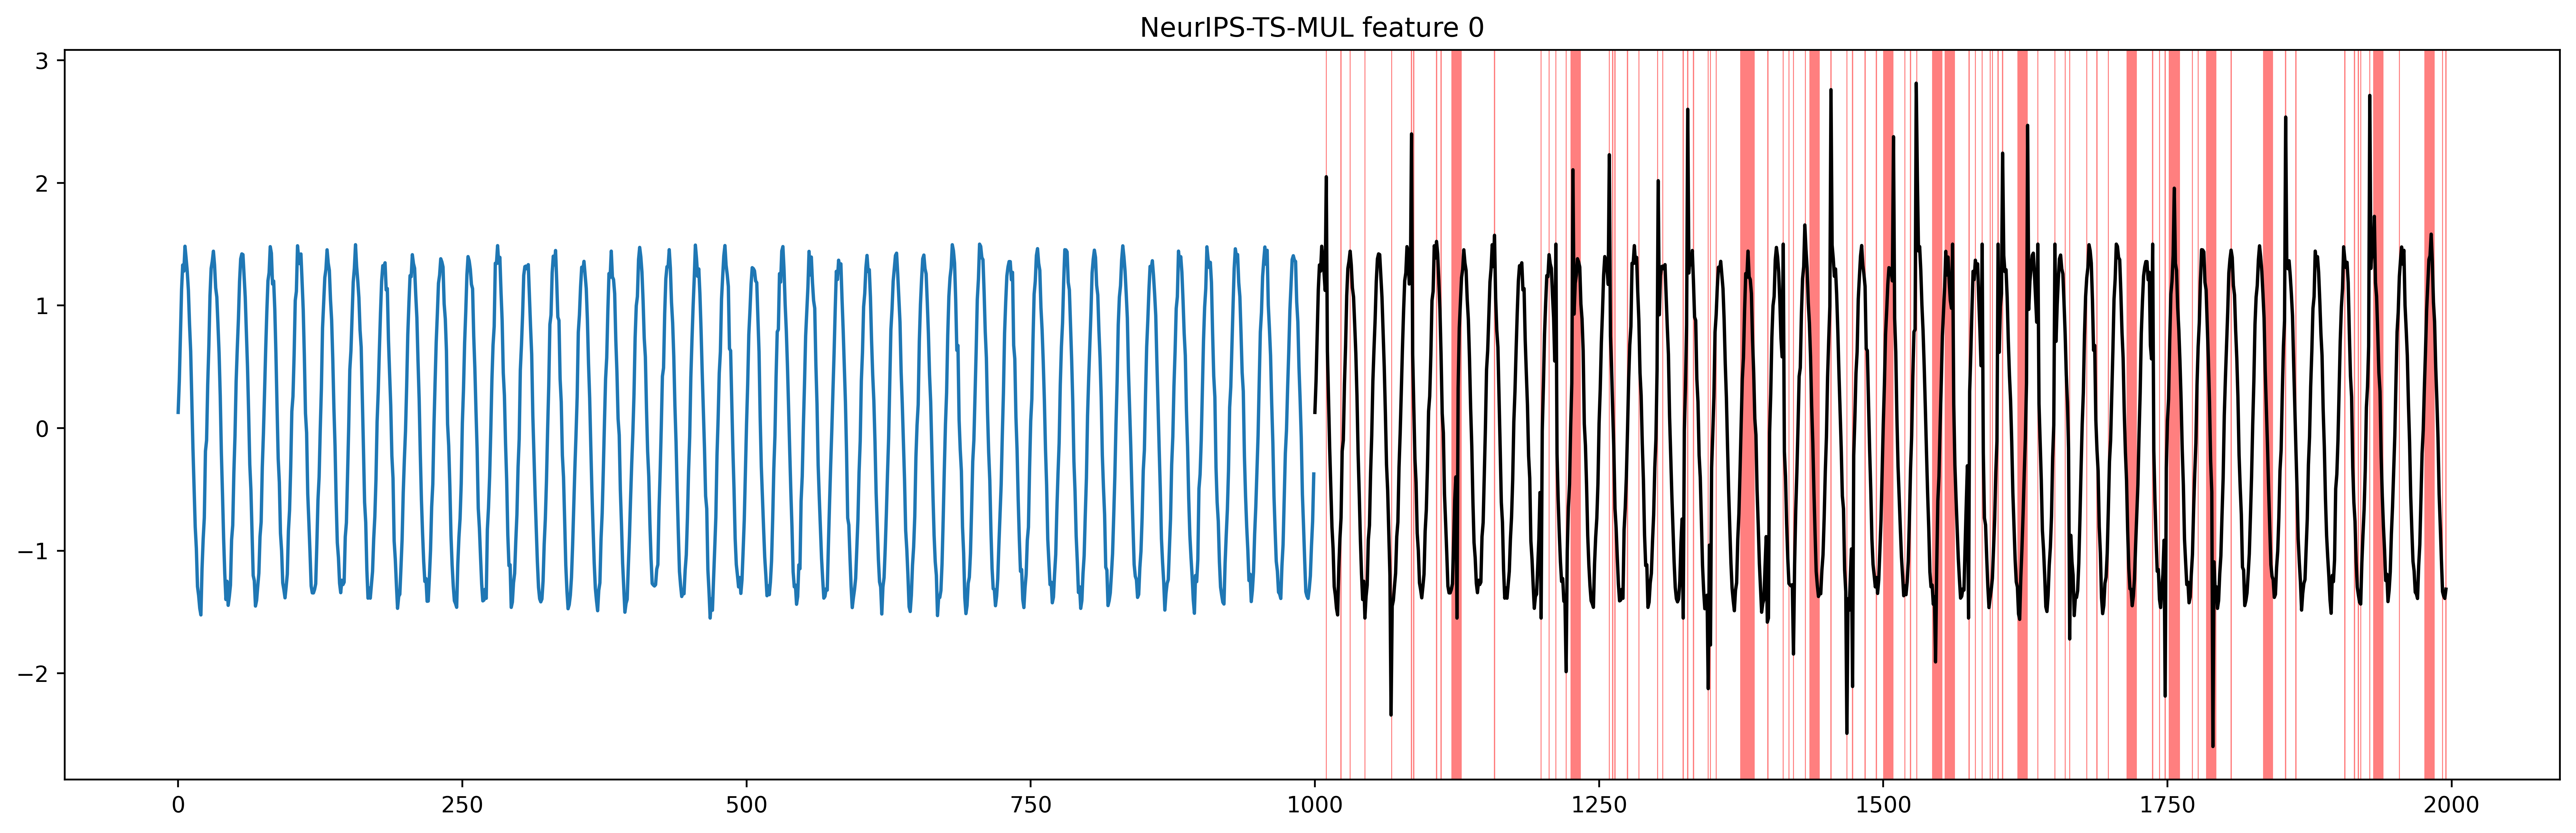

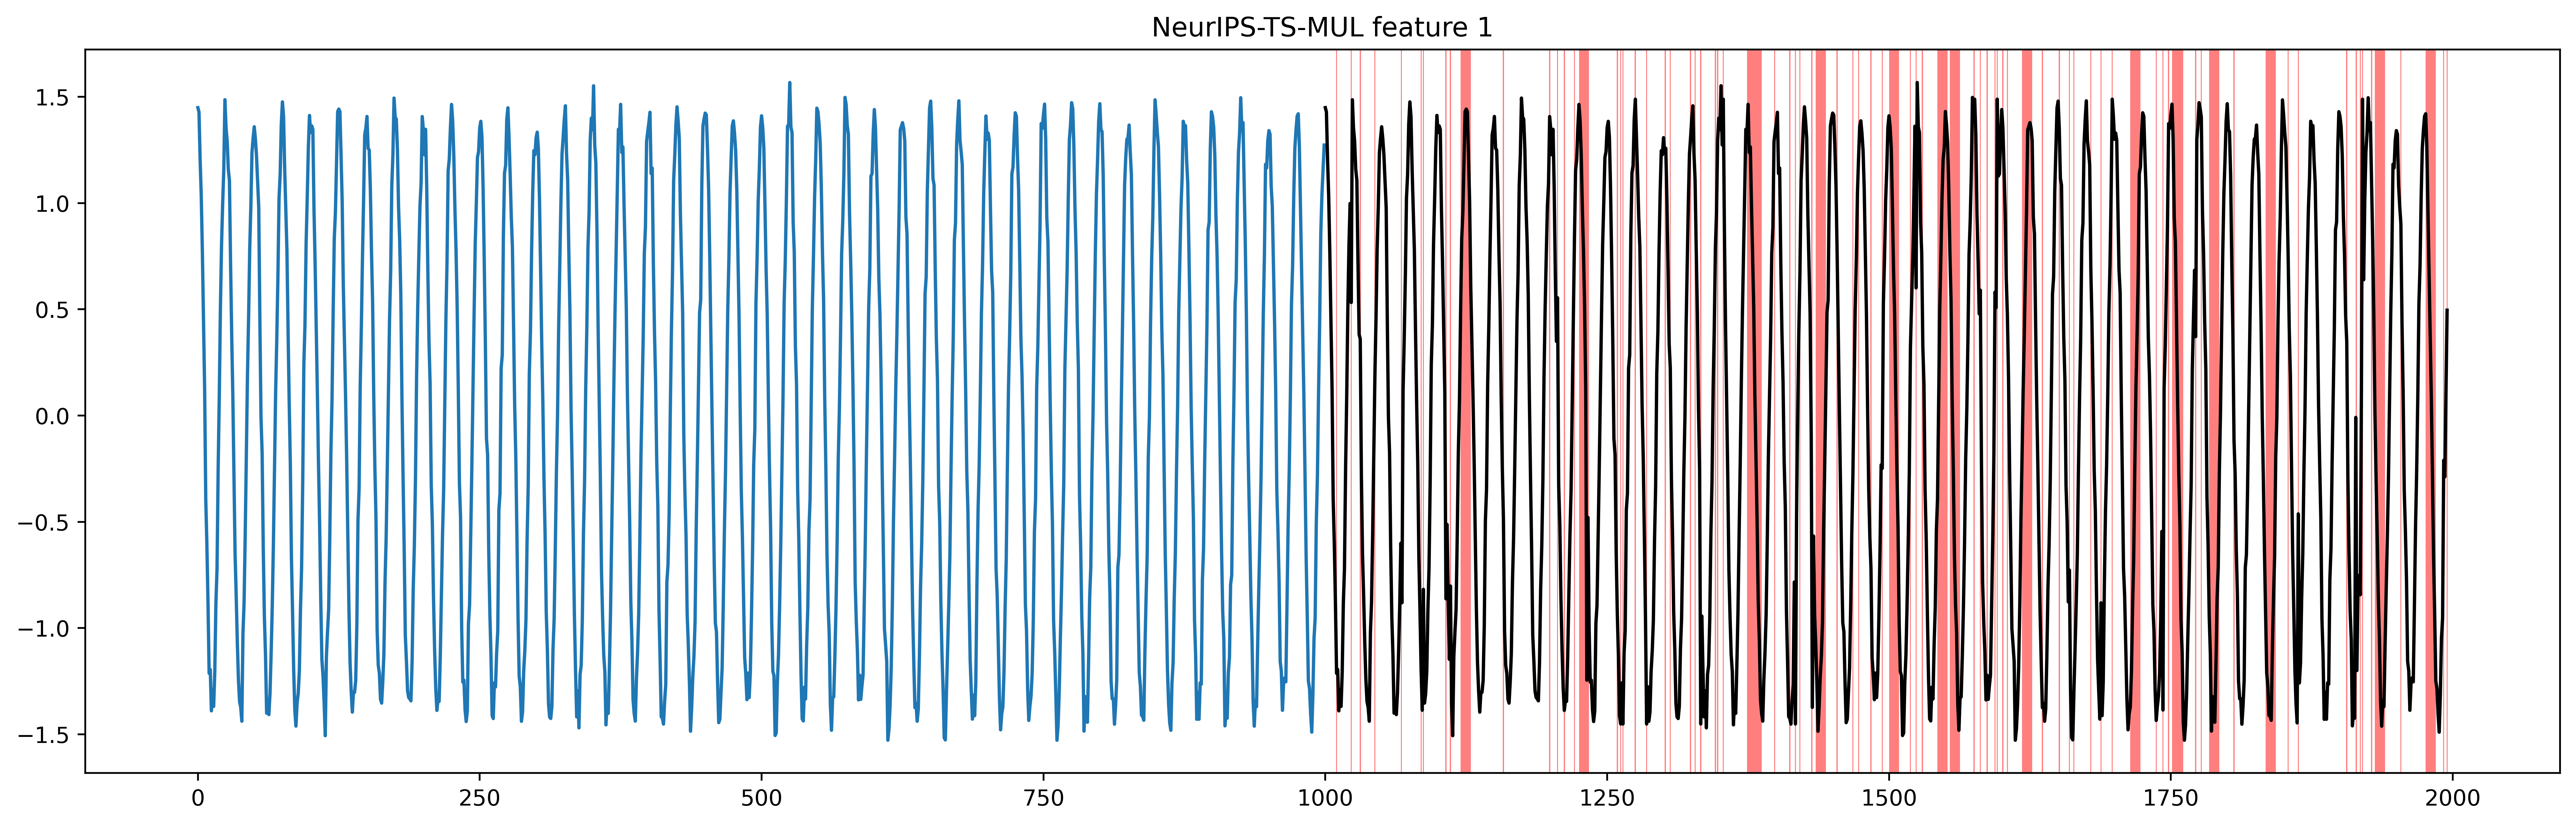

KeyboardInterrupt: 

In [22]:
for c in range(args.num_channels):
    dataset_name = "SWaT"
    plt.figure(figsize=(20, 6), dpi=500)
    plt.plot(train_X[:, c], color="C0")
    plt.plot(range(len(train_X), len(train_X)+len(test_X)), test_X[:, c], color="black")
    label = np.concatenate([np.array([0]*len(train_X)), test_y])
    plot_interval(plt, label)
    plt.title(f"{dataset_name} feature {c}")
    plt.show()

## Load Model

In [5]:
tester = MLP_Tester(
    args=args,
    logger=logger,
    train_loader=train_loader,
    test_loader=test_loader,
)
tester.load(os.path.join("./checkpoints/MLP_SWaT_RevIN_ARevIN", f"best.pth"))

[2023-04-10 22:32:46,599] loading: ./checkpoints/MLP_SWaT_RevIN_ARevIN/best.pth @Trainer - torch.load_state_dict
[2023-04-10 22:32:46,720] train_errors.pt file does not exist, calculating...
calculating reconstruction errors: 100%|██████████| 7763/7763 [00:11<00:00, 665.70it/s]
[2023-04-10 22:32:58,454] saving train_errors.pt...
[2023-04-10 22:32:59,003] test_errors.pt file does not exist, calculating...
calculating reconstruction errors: 100%|██████████| 37493/37493 [00:25<00:00, 1448.29it/s]
[2023-04-10 22:33:24,968] saving test_errors.pt...
[2023-04-10 22:33:25,275] Best threshold found at: 9.518744468688965, with fpr: 0.004940151568807989, tpr: 0.6194855635351019
tn: 393380 fn: 20770
fp: 1952 tp: 33814
[2023-04-10 22:33:25,276] loading: ./checkpoints/MLP_SWaT_RevIN_ARevIN/best.pth @Trainer - torch.load_state_dict


In [6]:
next(iter(tester.model.parameters())).device, next(iter(tester.model.parameters())).requires_grad

(device(type='cuda', index=0), True)

In [7]:
tester.model.state_dict()

OrderedDict([('encoder.linear1.weight',
              tensor([[-1.3466e-01, -7.5767e-02,  7.7187e-02,  ...,  4.7431e-03,
                        1.3172e-01,  9.3044e-03],
                      [ 8.3413e-02,  1.0936e-01, -1.0702e-01,  ...,  2.8408e-02,
                       -1.2378e-01,  2.1300e-02],
                      [ 1.0617e-01, -5.7959e-02,  1.4859e-01,  ..., -2.2359e-06,
                       -1.0408e-01,  6.7766e-03],
                      ...,
                      [ 5.3771e-02,  3.8205e-02,  8.7450e-02,  ..., -2.6376e-02,
                       -4.1608e-02, -5.5790e-03],
                      [ 7.9750e-02,  1.9810e-02, -8.7248e-02,  ...,  3.3043e-02,
                       -6.4403e-02,  2.4957e-02],
                      [ 1.0520e-03, -1.1242e-01,  6.0832e-02,  ..., -3.0857e-02,
                        1.3589e-01,  2.0290e-02]], device='cuda:0')),
             ('encoder.linear1.bias',
              tensor([-0.1039, -1.1501, -1.0700, -0.6656, -1.0107, -0.4844, -1.5047, -0.4

## Training statistics

In [8]:
train_iterator = tqdm(
    tester.train_loader,
    total=len(tester.train_loader),
    desc="calculating reconstruction errors",
    leave=True
)

recon_errors = []
with torch.no_grad():
    for i, batch_data in enumerate(train_iterator):
        X = batch_data[0].to(args.device)
        B, L, C = X.shape
        Xhat = tester.model(X)
        recon_error = torch.nn.functional.mse_loss(Xhat, X, reduction='none')
        recon_errors.append(recon_error)

recon_errors = torch.cat(recon_errors, axis=0)

train_error_dist = recon_errors.mean(dim=(1, 2))

print(f"{recon_errors.shape}, {train_error_dist.shape}")

calculating reconstruction errors: 100%|██████████| 7763/7763 [00:11<00:00, 673.56it/s]

torch.Size([496789, 12, 51]), torch.Size([496789])


## Test: static threshold inference

In [9]:
eval_iterator = tqdm(
    tester.test_loader,
    total=len(tester.test_loader),
    desc="calculating reconstruction errors",
    leave=True
)

anoscs_prev = []
Xhats_prev = []
with torch.no_grad():
    for i, batch_data in enumerate(eval_iterator):
        X, y = batch_data[0].to(args.device), batch_data[1].to(args.device)
        B, L, C = X.shape
        Xhat = tester.model(X)
        Xhats_prev.append(Xhat)        
        e = F.mse_loss(Xhat, X, reduction='none')
        anosc = e.mean(dim=2)
        anoscs_prev.append(anosc)

Xhats_prev = torch.cat(Xhats_prev, axis=0).detach().cpu().numpy()
anoscs_prev = torch.cat(anoscs_prev, axis=0).reshape(-1).detach().cpu().numpy()

calculating reconstruction errors: 100%|██████████| 37493/37493 [00:27<00:00, 1341.84it/s]


In [10]:
th_q95 = torch.quantile(train_error_dist, 0.95).item()
th_q99 = torch.quantile(train_error_dist, 0.99).item()
th_q100 = torch.max(train_error_dist).item()
th_best_static = tester.get_best_static_threshold(gt=test_y, anomaly_scores=anoscs_prev)
th_q95, th_q99, th_q100, th_best_static

[2023-04-10 22:34:31,699] Best threshold found at: 9.566165924072266, with fpr: 0.004930033490838081, tpr: 0.6128535834676828
tn: 393383 fn: 21132
fp: 1949 tp: 33452


(0.016090188175439835, 0.13804008066654205, 5.90606689453125, 9.566166)

In [11]:
# 95
print(get_summary_stats(test_dataset.y, anoscs_prev > th_q95))
# 99
print(get_summary_stats(test_dataset.y, anoscs_prev > th_q99))
# 100
print(get_summary_stats(test_dataset.y, anoscs_prev > th_q100))
# oracle
print(get_summary_stats(test_dataset.y, anoscs_prev > th_best_static))

{'Accuracy': 0.2917522381955743, 'Precision': 0.14216100776202245, 'Recall': 0.9609775758464019, 'F1': 0.2476815563320427, 'tn': 78810, 'fp': 316522, 'fn': 2130, 'tp': 52454}
{'Accuracy': 0.37328968074040486, 'Precision': 0.1511342819180764, 'Recall': 0.9023340172944453, 'F1': 0.2589040483818825, 'tn': 118696, 'fp': 276636, 'fn': 5331, 'tp': 49253}
{'Accuracy': 0.9462766383058171, 'Precision': 0.9031095087877422, 'Recall': 0.6241389418144512, 'F1': 0.7381455360915207, 'tn': 391677, 'fp': 3655, 'fn': 20516, 'tp': 34068}
{'Accuracy': 0.9486970901234897, 'Precision': 0.9449435028248587, 'Recall': 0.6128352630807563, 'F1': 0.7434877311522048, 'tn': 393383, 'fp': 1949, 'fn': 21133, 'tp': 33451}


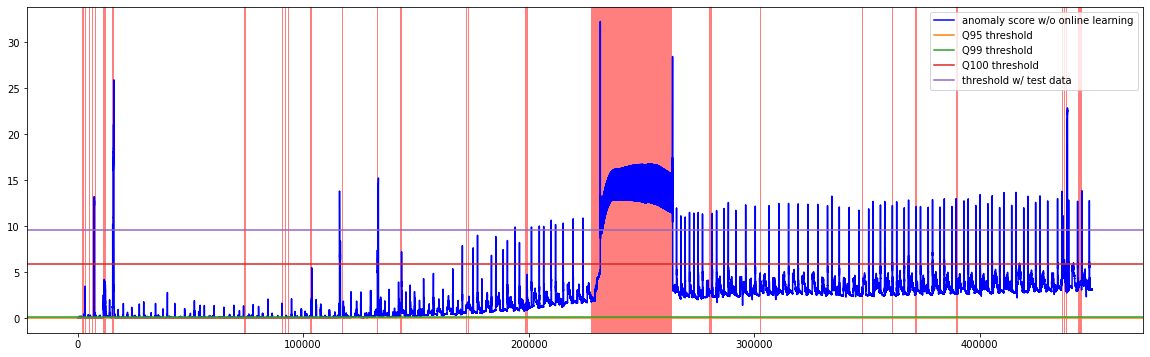

In [12]:
plt.figure(figsize=(20, 6))
#lt.ylim([-2, 5])
plt.plot(anoscs_prev, color="blue", label="anomaly score w/o online learning")
#plt.plot(anoscs, color="green", label="anomaly score w/ online learning")
plt.axhline(th_q95, color="C1", label="Q95 threshold")
plt.axhline(th_q99, color="C2", label="Q99 threshold")
plt.axhline(th_q100, color="C3", label="Q100 threshold")
plt.axhline(th_best_static, color="C4", label="threshold w/ test data")

#plt.plot(thrs, color="gold",label="dynamic threshold")
plt.legend()
plot_interval(plt, test_y)
plt.show()

## Value-based Pseudo-label guided Online Learning (separate threshold)

### 1. Single+CE

In [110]:
thr = init_thr = torch.quantile(train_error_dist, 0.95).detach().item()
thr = torch.tensor(thr, requires_grad=True)
thr

tensor(0.0161, requires_grad=True)

In [111]:
tester = MLP_Tester(
    args=args,
    logger=logger,
    train_loader=train_loader,
    test_loader=test_loader,
)
tester.load(os.path.join("./checkpoints/MLP_SWaT_RevIN_ARevIN", f"best.pth"))

[2023-04-10 23:44:23,212] loading: ./checkpoints/MLP_SWaT_RevIN_ARevIN/best.pth @Trainer - torch.load_state_dict
[2023-04-10 23:44:23,220] train_errors.pt file exists, loading...
[2023-04-10 23:44:23,232] torch.Size([496789, 12])
[2023-04-10 23:44:23,243] test_errors.pt file exists, loading...
[2023-04-10 23:44:23,245] torch.Size([37493, 12])
[2023-04-10 23:44:23,530] Best threshold found at: 9.518744468688965, with fpr: 0.004940151568807989, tpr: 0.6194855635351019
tn: 393380 fn: 20770
fp: 1952 tp: 33814
[2023-04-10 23:44:23,531] loading: ./checkpoints/MLP_SWaT_RevIN_ARevIN/best.pth @Trainer - torch.load_state_dict


In [112]:
tester.model.revin.mean

Parameter containing:
tensor([[[ 2.0572e-02, -1.7546e-02,  1.9793e-02,  4.5670e-03,  0.0000e+00,
          -1.2377e-02,  4.6628e-03,  7.7784e-03,  4.0972e-03,  5.5763e-03,
           0.0000e+00,  0.0000e+00,  4.8557e-03,  0.0000e+00, -5.5183e-05,
           0.0000e+00, -2.8138e-03, -1.2339e-04,  8.9447e-03,  1.0833e-02,
          -3.9866e-03, -8.3792e-04,  1.0303e-02, -2.9605e-03,  9.9303e-04,
          -3.9509e-03,  8.0220e-03, -7.4760e-03,  5.9314e-03,  0.0000e+00,
          -8.0700e-03,  0.0000e+00,  0.0000e+00, -7.9380e-03, -7.4860e-03,
           9.6268e-03, -6.2879e-03,  4.5814e-03, -7.3466e-03, -7.7281e-03,
          -6.5927e-03, -6.6011e-03, -5.5802e-03,  0.0000e+00, -5.9387e-03,
          -4.8192e-03, -5.7561e-03, -2.4798e-03,  0.0000e+00,  6.5527e-03,
           0.0000e+00]]], device='cuda:0')

In [113]:
tester.model.revin.gamma = 0.99999
tester.model.revin.gamma

0.99999

In [114]:
eval_iterator = tqdm(
    tester.test_loader,
    total=len(tester.test_loader),
    desc="calculating reconstruction errors",
    leave=True
)

lr = 1e-03
TT_optimizer = torch.optim.SGD([p for p in tester.model.parameters()], lr=lr)
TH_optimizer = torch.optim.SGD([thr], lr=lr)
bce = torch.nn.BCELoss()

Xs, Xhats = [], []
yhats = []
preds = []
As, thrs =[], []

for i, batch_data in enumerate(eval_iterator):
    X, y = batch_data[0].to(tester.args.device), batch_data[1].to(tester.args.device)
    B, L, C = X.shape
    
    # inference
    #import pdb;pdb.set_trace();
    tester.model.revin._update_statistics(X)
    
    Xhat = tester.model(X)
    E = F.mse_loss(Xhat, X, reduction='none')
    A = E.mean(dim=2)
    
    thrp = torch.clamp(thr, min=init_thr)

    ytilde = (A > thrp).float()
    pred = (A > thrp)
    
    # log source model outputs
    Xs.append(X)
    Xhats.append(Xhat.clone().detach())
    As.append(A.clone().detach())
    preds.append(pred.clone().detach())
    thrs.append(thr.clone().detach().item())
    
    # learn new-normals
    TT_optimizer.zero_grad()
    mask = (ytilde == 0)
    recon_loss = (A*mask).mean()
    recon_loss.backward()
    TT_optimizer.step()
    
    # update threshold
    TH_optimizer.zero_grad()
    Xhat = tester.model(X)
    E = F.mse_loss(Xhat, X, reduction='none')
    A = E.mean(dim=2)
    yhat = torch.sigmoid((A-thrp))
    cls_loss = bce(yhat, ytilde)
    cls_loss.backward()
    TH_optimizer.step()
    
    
Xs = torch.cat(Xs, axis=0).detach().cpu().numpy()    
Xhats = torch.cat(Xhats, axis=0).detach().cpu().numpy()

anoscs = torch.cat(As, axis=0).reshape(-1).detach().cpu().numpy()
thrs = np.repeat(np.array(thrs), args.window_size*args.eval_batch_size)
preds = torch.cat(preds).reshape(-1).detach().cpu().numpy()

calculating reconstruction errors: 100%|██████████| 37493/37493 [03:30<00:00, 178.47it/s]


In [115]:
print(test_y.shape, preds.shape)
single_CE = get_summary_stats(test_y, preds)
print(single_CE)

(449916,) (449916,)
{'Accuracy': 0.9549938210688217, 'Precision': 0.9677155700858193, 'Recall': 0.6507401436318335, 'F1': 0.7781879525463089, 'tn': 394147, 'fp': 1185, 'fn': 19064, 'tp': 35520}


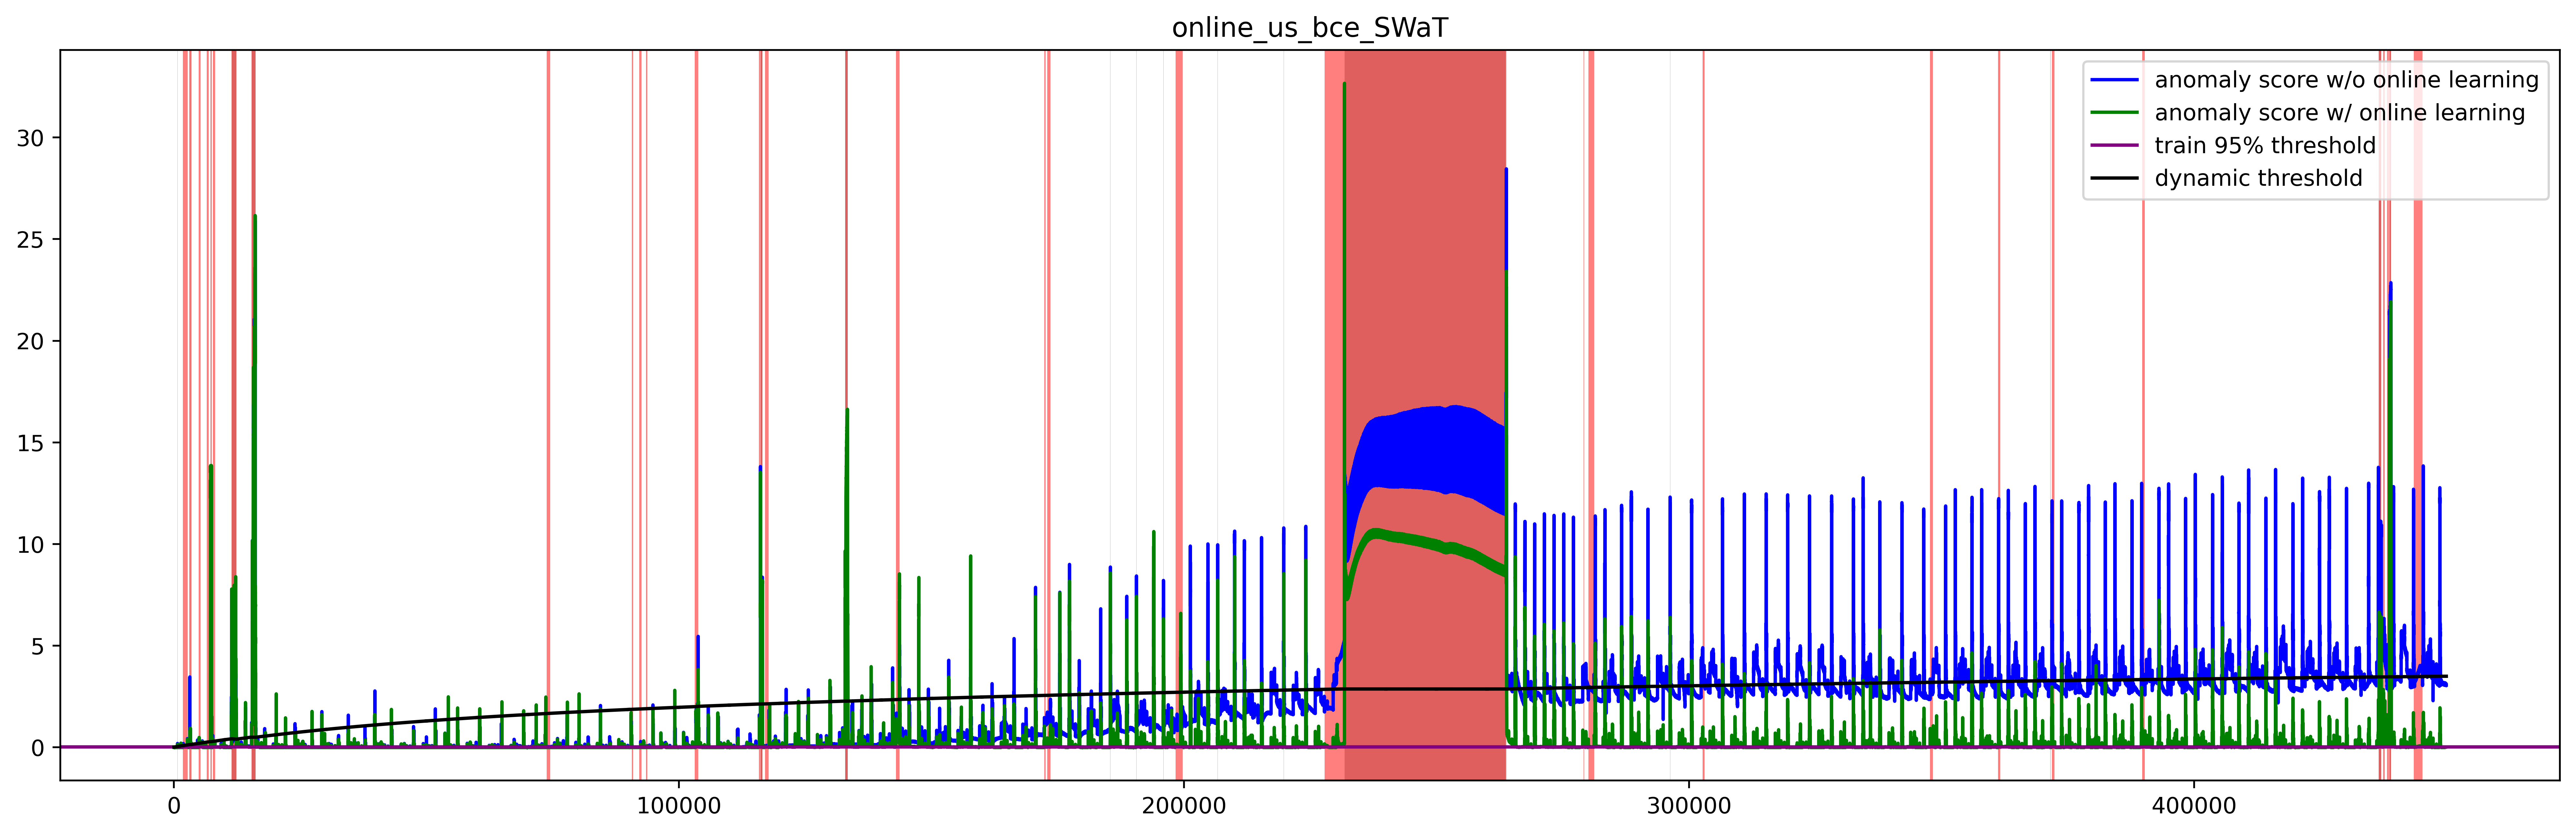

In [116]:
#s, e = 26751, 26851
s, e = 0, -1
plt.figure(figsize=(20, 6), dpi=500)
plt.title(f"online_us_bce_{args.dataset}")
#plt.ylim([-1, 5])
plt.plot(anoscs_prev[s:e], color="blue", label="anomaly score w/o online learning")
plt.plot(anoscs[s:e], color="green", label="anomaly score w/ online learning")
plt.axhline(th_q95, color="purple", label="train 95% threshold")
plt.plot(thrs[s:e], color="black",label="dynamic threshold")

plot_interval(plt, preds.astype(int)[s:e], facecolor="gray", alpha=0.5)
plot_interval(plt, test_y[s:e])
plt.legend()
plt.show()

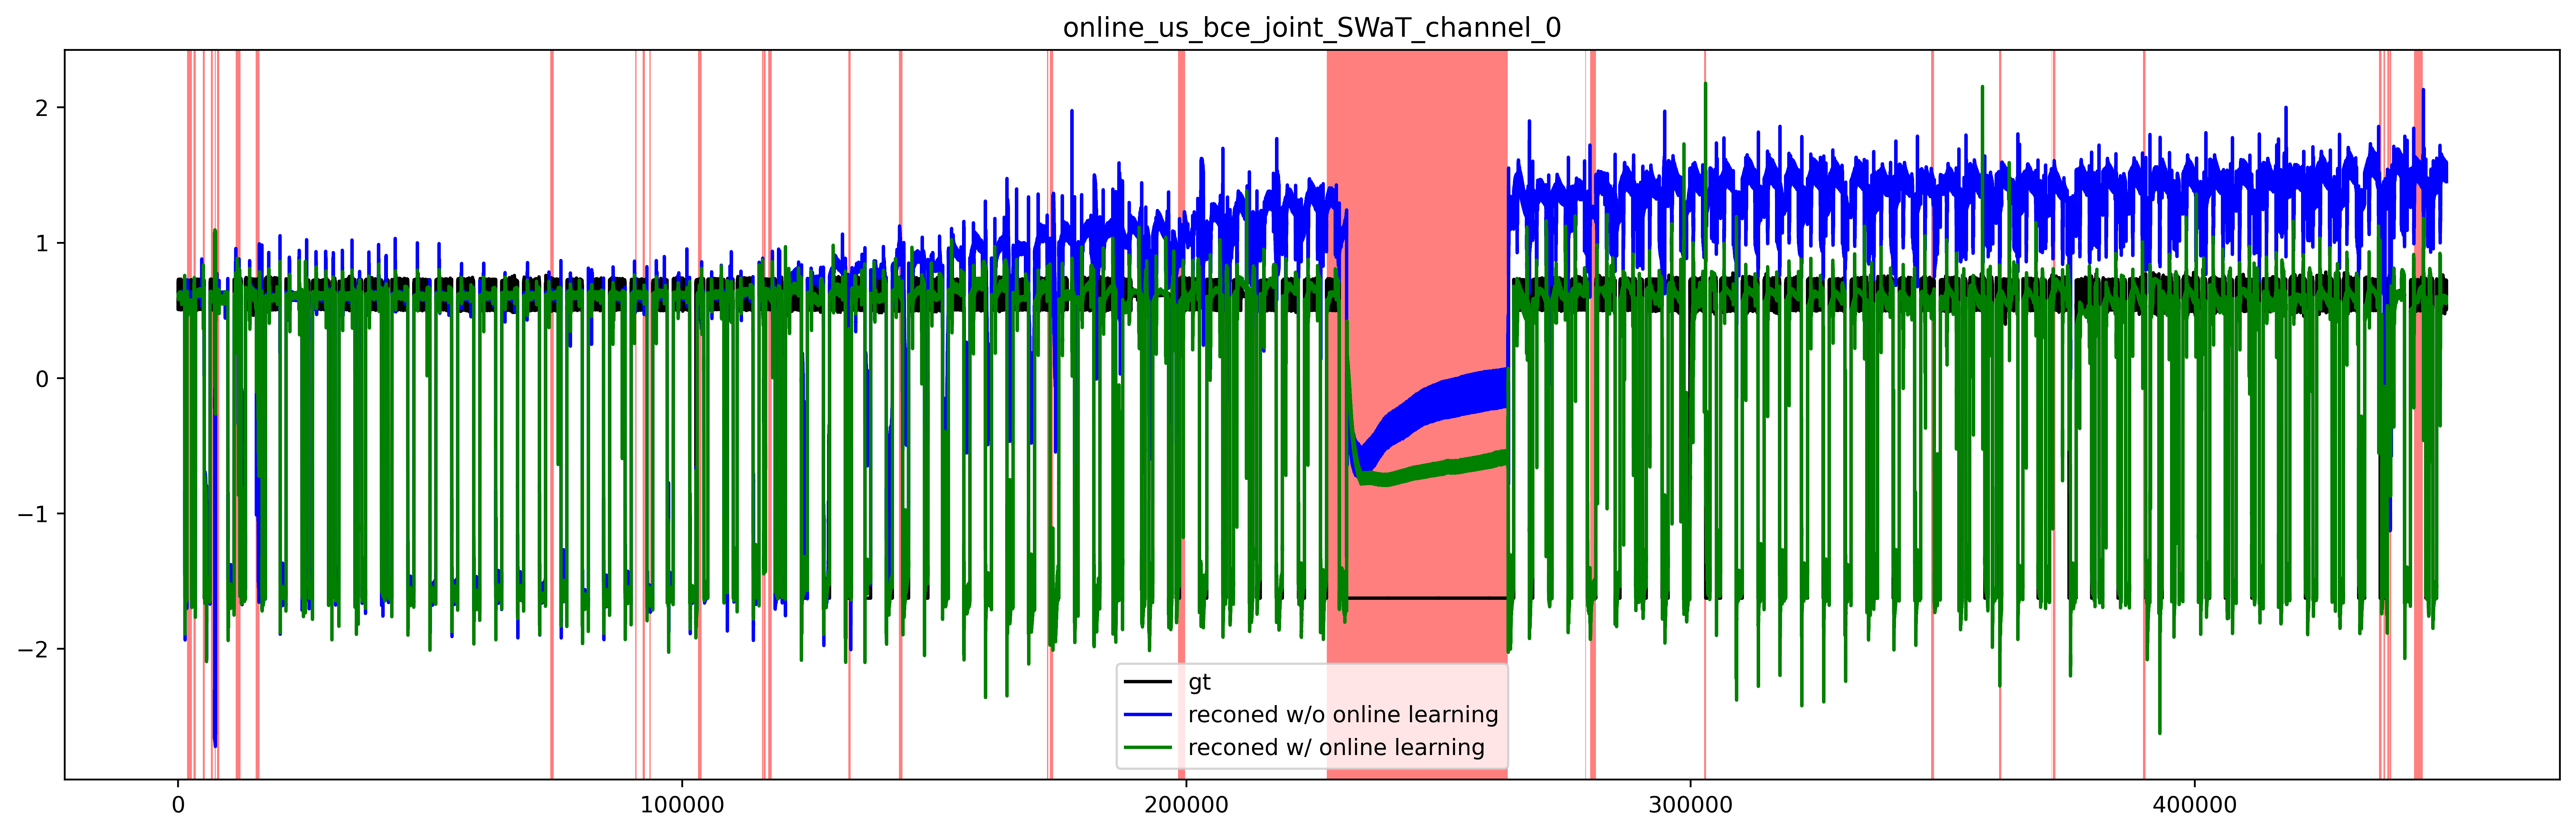

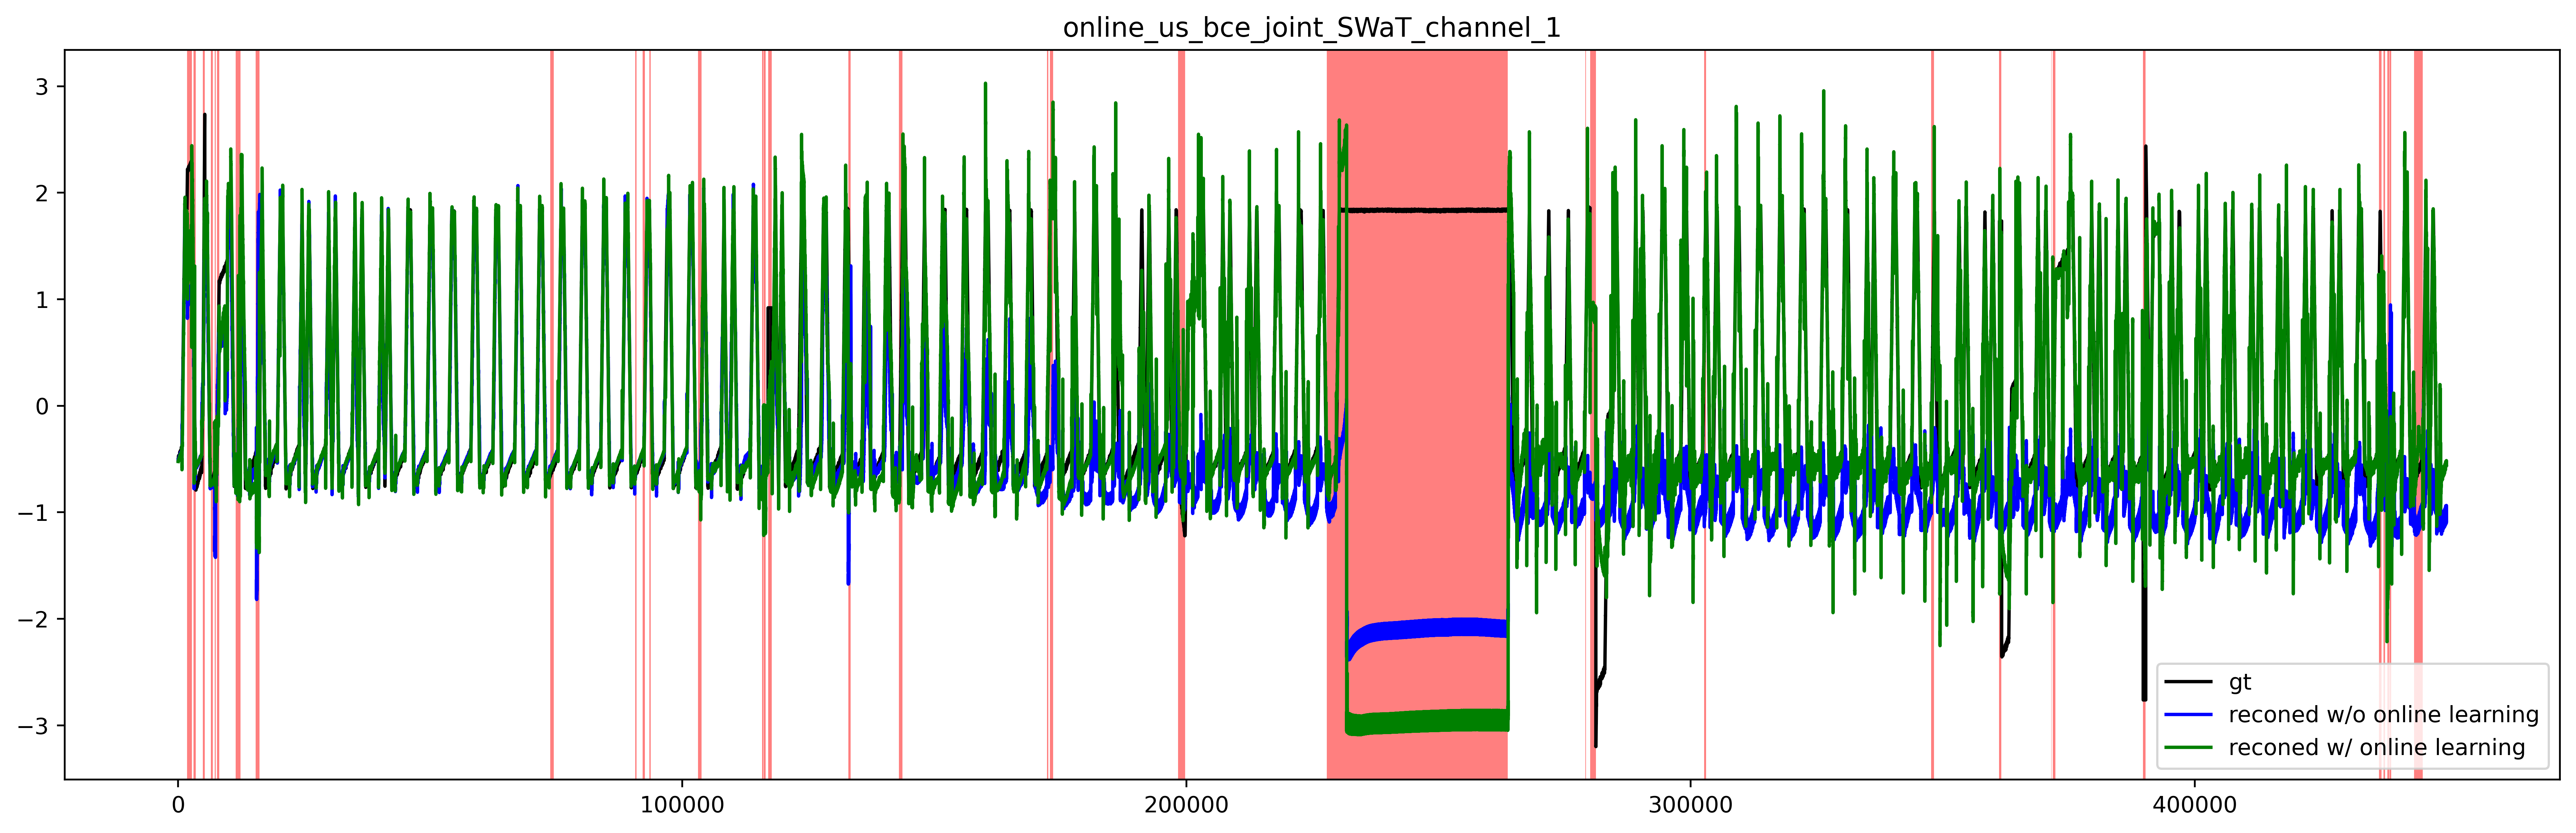

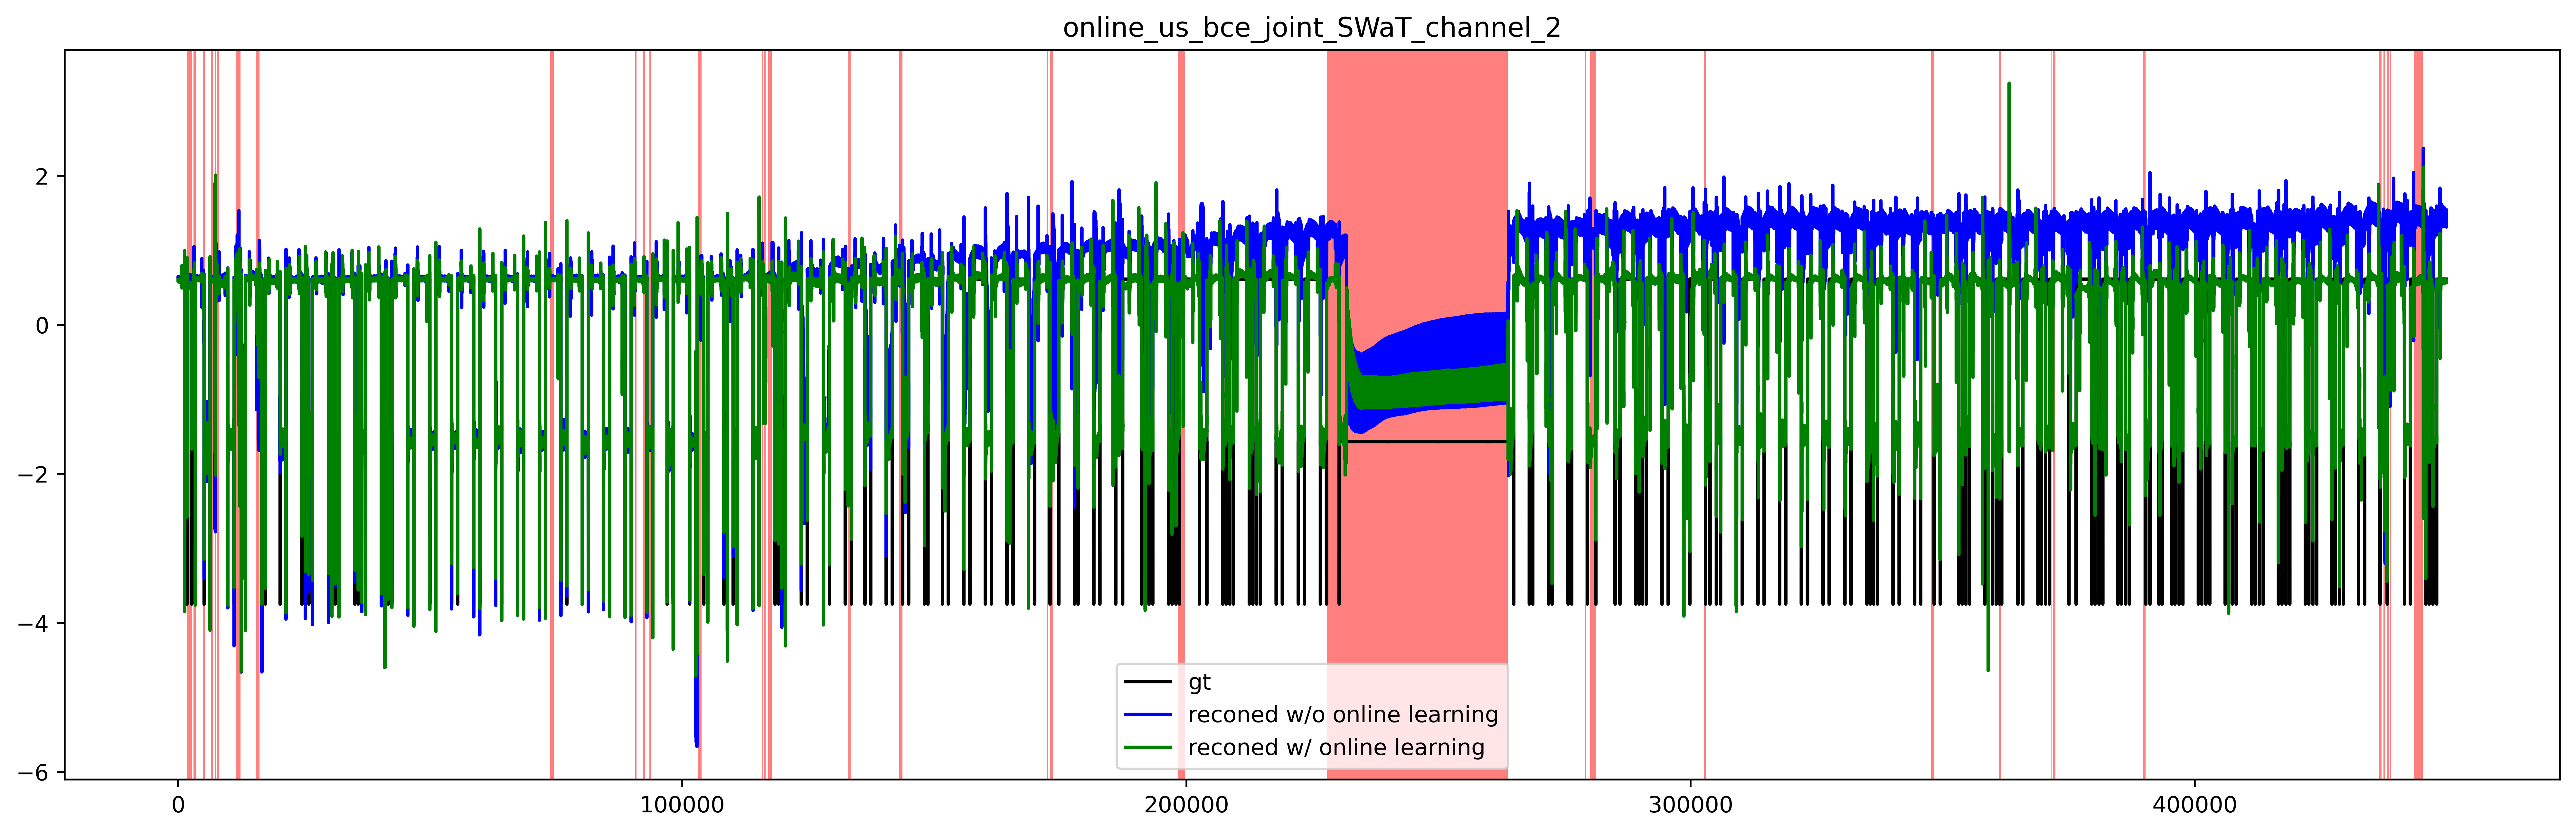

Error in callback <function flush_figures at 0x7f2a44628f70> (for post_execute):


KeyboardInterrupt: 

In [71]:
# plot recon
c = 0
for c in range(args.num_channels):
    test_X, test_y = test_dataset.X, test_dataset.y

    B, L, C = Xhats.shape

    plt.figure(figsize=(20, 6), dpi=500)
    plt.title(f"online_us_bce_joint_{args.dataset}_channel_{c}")

    plt.plot(test_X[:, c], color="black", label="gt")
    plt.plot(Xhats_prev[:,:,c].reshape(-1), color="blue", label="reconed w/o online learning")
    plt.plot(Xhats[:,:,c].reshape(-1), color="green", label="reconed w/ online learning")
    plt.legend()
    plot_interval(plt, test_y)

### Just learn normals

In [ ]:
thr = torch.quantile(train_error_dist, 0.95).detach().item()
thr

In [ ]:
tester = MLP_Tester(
    args=args,
    logger=logger,
    train_loader=train_loader,
    test_loader=test_loader,
)
tester.load(os.path.join("./checkpoints/MLP_SWaT", f"best.pth"))

In [ ]:
eval_iterator = tqdm(
    tester.test_loader,
    total=len(tester.test_loader),
    desc="calculating reconstruction errors",
    leave=True
)

lr = 1e-03
TT_optimizer = torch.optim.SGD([p for p in tester.model.parameters()], lr=lr)
bce = torch.nn.BCELoss()

Xs, Xhats = [], []
yhats = []
preds = []
As, thrs =[], []

for i, batch_data in enumerate(eval_iterator):
    X, y = batch_data[0].to(tester.args.device), batch_data[1].to(tester.args.device)
    B, L, C = X.shape
    
    # inference
    Xhat = tester.model(X)
    E = F.mse_loss(Xhat, X, reduction='none')
    A = E.mean(dim=2)
    ytilde = (A > thr).float()
    pred = (A > thr)
    
    # log source model outputs
    Xs.append(X)
    Xhats.append(Xhat.clone().detach())
    As.append(A.clone().detach())
    preds.append(pred.clone().detach())
    thrs.append(thr)
    
    # learn new-normals
    TT_optimizer.zero_grad()
    mask = (ytilde == 0)
    recon_loss = (A*mask).mean()
    recon_loss.backward()
    TT_optimizer.step()
    
Xs = torch.cat(Xs, axis=0).detach().cpu().numpy()    
Xhats = torch.cat(Xhats, axis=0).detach().cpu().numpy()

anoscs = torch.cat(As, axis=0).reshape(-1).detach().cpu().numpy()
thrs = np.repeat(np.array(thrs), args.window_size*args.eval_batch_size)
preds = torch.cat(preds).reshape(-1).detach().cpu().numpy()

In [ ]:
print(test_y.shape, preds.shape)
single_CE = get_summary_stats(test_y, preds)
print(single_CE)

In [ ]:
#s, e = 26751, 26851
s, e = 0, -1
plt.figure(figsize=(20, 6), dpi=500)
plt.title(f"online_us_bce_{args.dataset}")
plt.ylim([-1, 5])
plt.plot(anoscs_prev[s:e], color="blue", label="anomaly score w/o online learning")
plt.plot(anoscs[s:e], color="green", label="anomaly score w/ online learning")
plt.axhline(th_q95, color="purple", label="train 95% threshold")
plt.plot(thrs[s:e], color="black",label="dynamic threshold")

plot_interval(plt, test_y[s:e])
plot_interval(plt, preds.astype(int)[s:e], facecolor="gray", alpha=1)
plt.legend()
plt.show()

In [ ]:
# plot recon
c = 0
for c in range(args.num_channels):
    test_X, test_y = test_dataset.X, test_dataset.y

    B, L, C = Xhats.shape

    plt.figure(figsize=(20, 6), dpi=500)
    plt.title(f"online_us_bce_joint_{args.dataset}_channel_{c}")

    plt.plot(Xhats_prev[:,:,c].reshape(-1), color="blue", label="reconed w/o online learning")
    plt.plot(Xhats[:,:,c].reshape(-1), linewidth=0.5, color="green", label="reconed w/ online learning")
    plt.plot(test_X[:, c], color="black", label="gt")
    plt.legend()
    plot_interval(plt, test_y)
    break

### src-tgt network

In [ ]:
thr = torch.quantile(train_error_dist, 0.95).detach().item()
thr

In [ ]:
tester = MLP_Tester(
    args=args,
    logger=logger,
    train_loader=train_loader,
    test_loader=test_loader,
)
tester.load(os.path.join("./checkpoints/MLP_SWaT", f"best.pth"))


pretrained_model = tester.model
source_model = copy.deepcopy(pretrained_model)
target_model = copy.deepcopy(pretrained_model)
ema_updater = EMAUpdater(source_model, target_model, 0.99)

In [ ]:
eval_iterator = tqdm(
    tester.test_loader,
    total=len(tester.test_loader),
    desc="calculating reconstruction errors",
    leave=True
)

lr = 1e-03
TT_optimizer = torch.optim.SGD([p for p in source_model.parameters()], lr=lr)
bce = torch.nn.BCELoss()

Xs, Xhats = [], []
yhats = []
preds = []
As, thrs =[], []

for i, batch_data in enumerate(eval_iterator):
    X, y = batch_data[0].to(tester.args.device), batch_data[1].to(tester.args.device)
    B, L, C = X.shape
    
    with torch.no_grad():
        Xhat_tgt = target_model(X)
        E_tgt = (Xhat_tgt-X)**2
    Xhat_src = source_model(X)
    E_src = (Xhat_src-X)**2
    A = E_src.mean(dim=2)
    ytilde = (A > thr).float()
    pred = (A > thr)
    
    # log source model outputs
    Xs.append(X)
    Xhats.append(Xhat_src.clone().detach())
    As.append(A.clone().detach())
    preds.append(pred.clone().detach())
    thrs.append(thr)
    
    # learn new-normals
    TT_optimizer.zero_grad()
    mask = (ytilde == 0)
    
    if i>1000:
        flood_loss = torch.clamp(E_src-E_tgt, min=0).mean()
        flood_loss.backward()
    else:
        recon_loss = (A*mask).mean()
        recon_loss.backward()
    TT_optimizer.step()
    
Xs = torch.cat(Xs, axis=0).detach().cpu().numpy()    
Xhats = torch.cat(Xhats, axis=0).detach().cpu().numpy()

anoscs = torch.cat(As, axis=0).reshape(-1).detach().cpu().numpy()
thrs = np.repeat(np.array(thrs), args.window_size*args.eval_batch_size)
preds = torch.cat(preds).reshape(-1).detach().cpu().numpy()

In [ ]:
print(test_y.shape, preds.shape)
single_CE = get_summary_stats(test_y, preds)
print(single_CE)

In [ ]:
#s, e = 26751, 26851
s, e = 0, -1
plt.figure(figsize=(20, 6), dpi=500)
plt.title(f"online_us_bce_{args.dataset}")
plt.ylim([-1, 5])
plt.plot(anoscs_prev[s:e], color="blue", label="anomaly score w/o online learning")
plt.plot(anoscs[s:e], color="green", label="anomaly score w/ online learning")
plt.axhline(th_q95, color="purple", label="train 95% threshold")
plt.plot(thrs[s:e], color="black",label="dynamic threshold")

plot_interval(plt, test_y[s:e])
plot_interval(plt, preds.astype(int)[s:e], facecolor="gray", alpha=1)
plt.legend()
plt.show()

### Single + BCE + Label

In [ ]:
thr = torch.quantile(train_error_dist, 0.95).detach().item()
thr = torch.tensor(thr, requires_grad=True)
thr

In [ ]:
tester = MLP_Tester(
    args=args,
    logger=logger,
    train_loader=train_loader,
    test_loader=test_loader,
)
tester.load(os.path.join("./checkpoints/MLP_PSM", f"best.pth"))

In [ ]:
eval_iterator = tqdm(
    tester.test_loader,
    total=len(tester.test_loader),
    desc="calculating reconstruction errors",
    leave=True
)

lr = 1e-03
TT_optimizer = torch.optim.SGD([thr]+[p for p in tester.model.parameters()], lr=lr)
bce = torch.nn.BCELoss()

Xs, Xhats = [], []
yhats = []
preds = []
As, thrs =[], []

for i, batch_data in enumerate(eval_iterator):
    X, y = batch_data[0].to(tester.args.device), batch_data[1].to(tester.args.device)
    B, L, C = X.shape
    
    # inference
    Xhat = tester.model(X)
    E = F.mse_loss(Xhat, X, reduction='none')
    A = E.mean(dim=2)
    ytilde = (A > thr).float()
    pred = (A > thr)
    
    # log source model outputs
    Xs.append(X)
    Xhats.append(Xhat.clone().detach())
    As.append(A.clone().detach())
    preds.append(pred.clone().detach())
    thrs.append(thr.clone().detach().item())
    
    # learn new-normals and update threshold
    TT_optimizer.zero_grad()
    mask = (y == 0)
    yhat = torch.sigmoid((A - thr))
    cls_loss = bce(yhat, y.float())
    recon_loss = (A * mask).mean()
    loss = recon_loss + cls_loss
    loss.backward()
    TT_optimizer.step()
    
    
Xs = torch.cat(Xs, axis=0).detach().cpu().numpy()    
Xhats = torch.cat(Xhats, axis=0).detach().cpu().numpy()

anoscs = torch.cat(As, axis=0).reshape(-1).detach().cpu().numpy()
thrs = np.repeat(np.array(thrs), args.window_size*args.eval_batch_size)
preds = torch.cat(preds).reshape(-1).detach().cpu().numpy()

In [ ]:
# result summary
print(test_y.shape, preds.shape)
result = get_summary_stats(test_y, preds)
print(result)

In [ ]:
s, e = 0, -1
plt.figure(figsize=(20, 6), dpi=500)
plt.title(f"online_label_bce_joint_{args.dataset}")
plt.ylim([-1, 5])
plt.plot(anoscs_prev[s:e], color="blue", label="anomaly score w/o online learning")
plt.plot(anoscs[s:e], color="green", label="anomaly score w/ online learning")
plt.axhline(th_q95, color="purple", label="train 95% threshold")
plt.plot(thrs[s:e], color="black",label="dynamic threshold")

plot_interval(plt, test_y[s:e])
plot_interval(plt, preds.astype(int)[s:e], facecolor="gray", alpha=0.5)
plt.legend()
plt.show()

In [ ]:
# plot recon
c = 0
for c in range(args.num_channels):
    test_X, test_y = test_dataset.X, test_dataset.y

    B, L, C = Xhats.shape

    plt.figure(figsize=(20, 6), dpi=500)
    plt.title(f"online_us_bce_joint_{args.dataset}_channel_{c}")

    plt.plot(test_X[:, c], color="black", label="gt")
    plt.plot(Xhats_prev[:,:,c].reshape(-1), color="blue", label="reconed w/o online learning")
    plt.plot(Xhats[:,:,c].reshape(-1), linewidth=0.5, color="green", label="reconed w/ online learning")
    plt.legend()
    plot_interval(plt, test_y)